In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

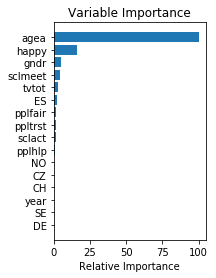

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [7]:
df.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,4.022622e+04,6.500307,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,1.496379,47.262182,1.384681
std,6.320721e+05,0.500031,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,0.500018,18.316890,0.486550
min,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,1.000000
25%,1.063000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,1.000000
50%,1.749000e+03,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,1.000000
75%,2.778000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,2.000000
max,1.100143e+07,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,2.000000


* I'm not really sure what kind of new features I would create.
* I can try subsampling next.

In [14]:
def run_the_model(params,X_train,X_test,y_train,y_test):
    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

In [16]:
# Subsampling
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'random_state': 99,
          'subsample': .8,}
run_the_model(params,X_train,X_test,y_train,y_test)

Training set accuracy:
Percent Type I errors: 0.04732678668848882
Percent Type II errors: 0.17416803055100927

Test set accuracy:
Percent Type I errors: 0.0736196319018405
Percent Type II errors: 0.18527607361963191


In [ ]:
# Higher iterations
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'random_state': 99,
          'subsample': .8,}
run_the_model(params,X_train,X_test,y_train,y_test)

### Waitaminute.
Why were we never told about GridSearchCV!? I'm a lot more apt to play with parameters if I can automate the really tedious parts of tuning.

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
params = {'n_estimators': range(50,1000,50),
          'max_depth': [2,10],
#          'subsample': range(.1,1.0,.1),
#          'min_samples_leaf': 50
         }
clf = ensemble.GradientBoostingClassifier(loss='deviance',random_state=99,subsample=.8,min_samples_leaf=50,)
gscv = GridSearchCV(clf,params,cv=5)

In [20]:
gscv.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort

In [21]:
#gscv.grid_scores_, 
gscv.best_params_, gscv.best_score_

({'max_depth': 2, 'n_estimators': 250}, 0.7477599116239106)

In [23]:
params = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
clf = ensemble.GradientBoostingClassifier(loss='deviance',
                                          random_state=99,
                                          min_samples_leaf=50,
                                          max_depth=2,
                                          n_estimators=250,)
gscv = GridSearchCV(clf,params,cv=5)

In [24]:
gscv.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=250,
                                                  n_iter_no_change=None,
                                                  presort

In [25]:
#gscv.grid_scores_, 
gscv.best_params_, gscv.best_score_

({'subsample': 0.85}, 0.7493555910150976)

In [31]:
gscv.cv_results_

{'mean_fit_time': array([0.89661121, 0.85852146, 0.84986992, 0.93752704, 0.82440057,
        0.83696909]),
 'std_fit_time': array([0.01035797, 0.01176648, 0.01835907, 0.07588543, 0.02911175,
        0.05932408]),
 'mean_score_time': array([0.00571861, 0.00571275, 0.00586338, 0.00591455, 0.00637155,
        0.00570064]),
 'std_score_time': array([0.00028704, 0.00040168, 0.00042265, 0.00059922, 0.00103446,
        0.00030003]),
 'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'subsample': 0.6},
  {'subsample': 0.7},
  {'subsample': 0.75},
  {'subsample': 0.8},
  {'subsample': 0.85},
  {'subsample': 0.9}],
 'split0_test_score': array([0.76687117, 0.76748466, 0.77300613, 0.76809816, 0.76993865,
        0.76932515]),
 'split1_test_score': array([0.70797546, 0.70736196, 0.70674847, 0.71840491, 0.7190184 ,
        0.71779141]),
 'split2_test_sc

In [27]:
# These are allegedly the best parameters.
params = {'loss': 'deviance',
          'random_state': 99,
          'min_samples_leaf': 50,
          'max_depth': 2,
          'n_estimators': 250,
          'subsample': .85,
         }

run_the_model(params,X_train,X_test,y_train,y_test)

Training set accuracy:
Percent Type I errors: 0.048554282596835786
Percent Type II errors: 0.18126022913256956

Test set accuracy:
Percent Type I errors: 0.05644171779141104
Percent Type II errors: 0.18650306748466258


I see that I didn't really do much to improve the Type II errors...but the Type I errors are slightly lower with these parameters.

In [29]:
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train,y_train)
y_pred = clf.predict(X)

In [34]:
from sklearn.metrics import confusion_matrix
so_confuse = confusion_matrix(y,y_pred)
so_confuse

array([[4611,  402],
       [1481, 1653]])

And if I'm using the correct metric, this is the best score I've seen so far in this exercise, so: wow. :)

In [35]:
from sklearn.metrics import accuracy_score
much_wow = accuracy_score(y,y_pred)
much_wow

0.7688719774149994